# Convolutional Autoencoder Training for L1Trigger

## Packages

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

## Read input files

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

### Backgrounds

In [2]:
ZeroBias = np.concatenate((h5py.File('bkg/ZeroBias_0.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_1.h5', 'r')['CaloRegions'][()],
                           h5py.File('bkg/ZeroBias_2.h5', 'r')['CaloRegions'][()]))
ZeroBias = ZeroBias.astype(dtype = 'float32').reshape(ZeroBias.shape[0], 18, 14, 1)
print(ZeroBias.shape)

#QCD = np.concatenate((h5py.File('bkg/110X/QCD_0.h5', 'r')['CaloRegions'][()],
#                      h5py.File('bkg/110X/QCD_1.h5', 'r')['CaloRegions'][()],
#                      h5py.File('bkg/110X/QCD_2.h5', 'r')['CaloRegions'][()]))
QCD = h5py.File('bkg/110X/QCD_0.h5', 'r')['CaloRegions'][()]
QCD = QCD.astype(dtype = 'float32').reshape(QCD.shape[0], 18, 14, 1)
print(QCD.shape)
QCD = QCD[:100000, :, :, :]
print(QCD.shape)

SingleNu_E10 = np.concatenate((h5py.File('bkg/120X/SingleNeutrino_E-10_0.h5', 'r')['CaloRegions'][()],
                                     h5py.File('bkg/120X/SingleNeutrino_E-10_1.h5', 'r')['CaloRegions'][()],
                                     h5py.File('bkg/120X/SingleNeutrino_E-10_2.h5', 'r')['CaloRegions'][()]))
SingleNu_E10 = SingleNu_E10.astype(dtype = 'float32').reshape(SingleNu_E10.shape[0], 18, 14, 1)
print(SingleNu_E10.shape)
SingleNu_E10 = SingleNu_E10[:100000, :, :, :]
print(SingleNu_E10.shape)

SingleNu_Pt2To20 = np.concatenate((h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_0.h5', 'r')['CaloRegions'][()],
                                         h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_1.h5', 'r')['CaloRegions'][()],
                                         h5py.File('bkg/120X/SingleNeutrino_Pt-2To20_2.h5', 'r')['CaloRegions'][()]))
SingleNu_Pt2To20 = SingleNu_Pt2To20.astype(dtype = 'float32').reshape(SingleNu_Pt2To20.shape[0], 18, 14, 1)
print(SingleNu_Pt2To20.shape)
SingleNu_Pt2To20 = SingleNu_Pt2To20[:100000, :, :, :]
print(SingleNu_Pt2To20.shape)

(315766, 18, 14, 1)
(2400000, 18, 14, 1)
(100000, 18, 14, 1)
(976000, 18, 14, 1)
(100000, 18, 14, 1)
(995000, 18, 14, 1)
(100000, 18, 14, 1)


### Signals

In [3]:
signal_files = []
signal_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=0
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
signal_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
signal_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=10
signal_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=20
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=30
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=40
signal_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
signal_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=48

signals = []
for i in range(len(signal_files)):
    signals.append(h5py.File(signal_files[i], 'r')['CaloRegions'][()].astype(dtype = 'float32'))
    signals[i] = signals[i].reshape(signals[i].shape[0], 18, 14, 1)
    print(str(i) + ': ' + str(signals[i].shape))

0: (50000, 18, 14, 1)
1: (39851, 18, 14, 1)
2: (40000, 18, 14, 1)
3: (13000, 18, 14, 1)
4: (40000, 18, 14, 1)
5: (300000, 18, 14, 1)
6: (30000, 18, 14, 1)
7: (291000, 18, 14, 1)
8: (1854, 18, 14, 1)
9: (38023, 18, 14, 1)
10: (6285, 18, 14, 1)
11: (50000, 18, 14, 1)
12: (50000, 18, 14, 1)
13: (50000, 18, 14, 1)
14: (300000, 18, 14, 1)
15: (100000, 18, 14, 1)
16: (100000, 18, 14, 1)
17: (39987, 18, 14, 1)
18: (39985, 18, 14, 1)
19: (35302, 18, 14, 1)
20: (31255, 18, 14, 1)
21: (33454, 18, 14, 1)
22: (40000, 18, 14, 1)
23: (34144, 18, 14, 1)
24: (34533, 18, 14, 1)
25: (29768, 18, 14, 1)
26: (18805, 18, 14, 1)
27: (39229, 18, 14, 1)
28: (30055, 18, 14, 1)
29: (38482, 18, 14, 1)
30: (32293, 18, 14, 1)
31: (40000, 18, 14, 1)
32: (33214, 18, 14, 1)
33: (29860, 18, 14, 1)
34: (1420, 18, 14, 1)
35: (37639, 18, 14, 1)
36: (27488, 18, 14, 1)
37: (32150, 18, 14, 1)
38: (41783, 18, 14, 1)
39: (500000, 18, 14, 1)
40: (178468, 18, 14, 1)
41: (36472, 18, 14, 1)
42: (98476, 18, 14, 1)
43: (100000, 18, 

## Create overlaid samples (ZB + signals) for test

In [4]:
#Overlay signal events on top of ZB before testing
#Simple addition tower by tower: overlaid signal = ZB + signal
#ZB is chosen at random for each signal event before overlaying them
np.random.seed(0)
signals_zb = []
for i in range(len(signals)):
    signals_zb.append(np.empty((signals[i].shape[0], 18, 14, 1)))
    ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = signals[i].shape[0])
    for j in range(signals[i].shape[0]):
        signals_zb[i][j, :, :, 0] = ZeroBias[ZB_random_event[j], :, :, 0] + signals[i][j, :, :, 0]

In [5]:
#Overlay QCD events on top of ZB
np.random.seed(0)
QCD_zb = np.empty((QCD.shape[0], 18, 14, 1))
ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = QCD.shape[0])
for i in range(QCD.shape[0]):
    QCD_zb[i, :, :, 0] = ZeroBias[ZB_random_event[i], :, :, 0] + QCD[i, :, :, 0]

In [6]:
#Overlay neutrino events on top of ZB
np.random.seed(0)
SingleNu_E10_zb = np.empty((SingleNu_E10.shape[0], 18, 14, 1))
ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = SingleNu_E10.shape[0])
for i in range(SingleNu_E10.shape[0]):
    SingleNu_E10_zb[i, :, :, 0] = ZeroBias[ZB_random_event[i], :, :, 0] + SingleNu_E10[i, :, :, 0]
    
SingleNu_Pt2To20_zb = np.empty((SingleNu_Pt2To20.shape[0], 18, 14, 1))
ZB_random_event = np.random.randint(low = 0, high = ZeroBias.shape[0], size = SingleNu_Pt2To20.shape[0])
for i in range(SingleNu_Pt2To20.shape[0]):
    SingleNu_Pt2To20_zb[i, :, :, 0] = ZeroBias[ZB_random_event[i], :, :, 0] + SingleNu_Pt2To20[i, :, :, 0]

SingleNu_Pt2To20


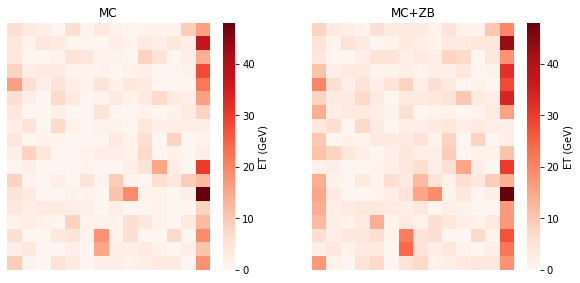

SingleNu_Pt2To20


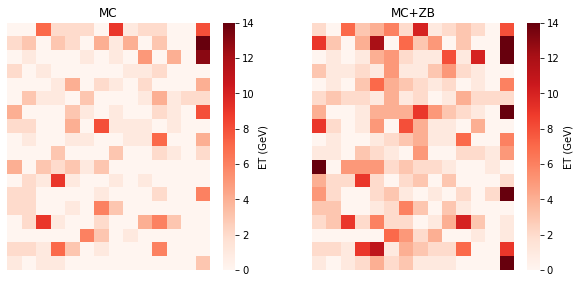

SingleNu_Pt2To20


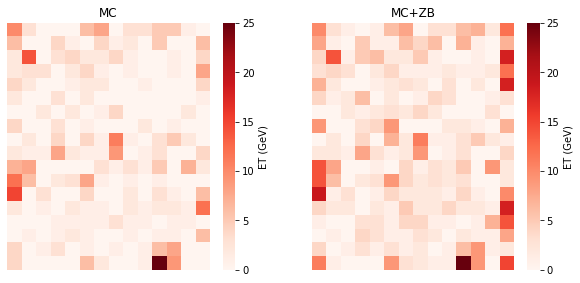

SingleNu_Pt2To20


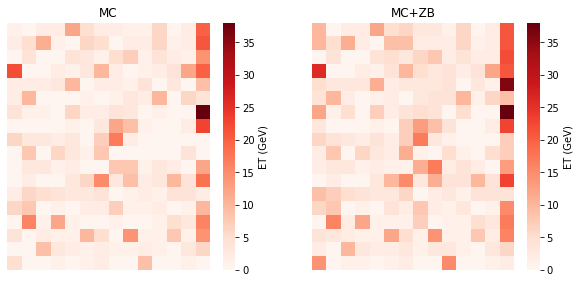

SingleNu_Pt2To20


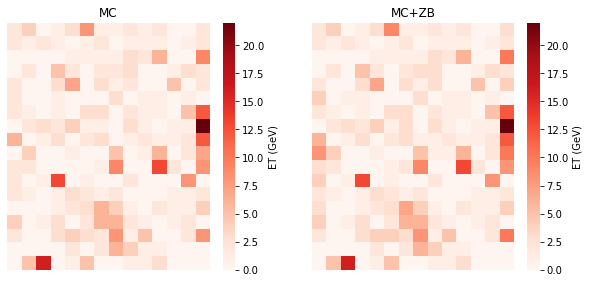

SingleNu_Pt2To20


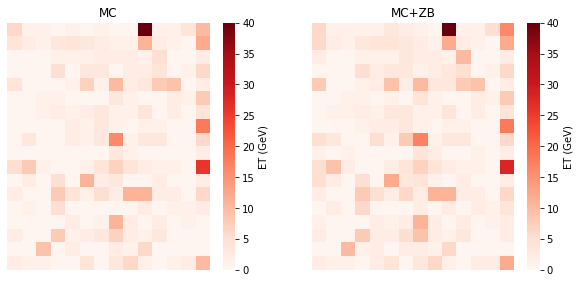

SingleNu_Pt2To20


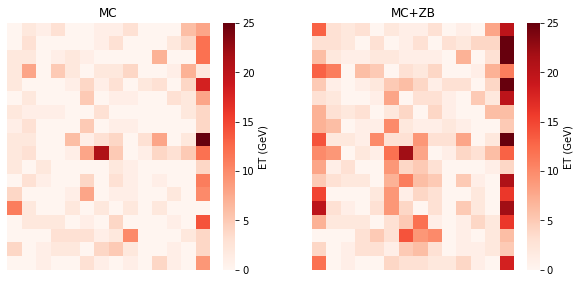

SingleNu_Pt2To20


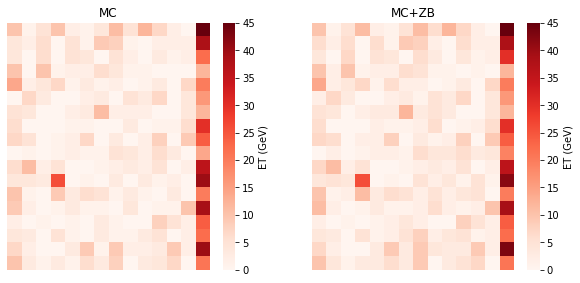

SingleNu_Pt2To20


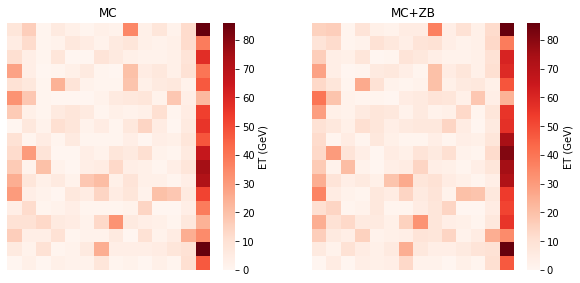

SingleNu_Pt2To20


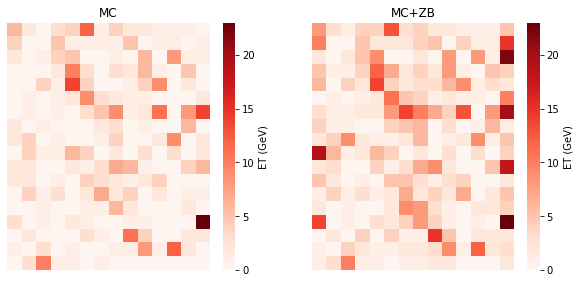

In [108]:
#Plot and compare signals/QCD/SingleNu before and after the overlay
n = 46
for i in range(40,50):
    fig, ax = plt.subplots(figsize = (10,10))
    #print(str(signal_files[n]))
    #print('QCD')
    #print('SingleNu_E10')
    print('SingleNu_Pt2To20')
    ax = plt.subplot(2, 2, 1)
    #ax = sns.heatmap(signals[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = signals[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(QCD[i,:,:,0].reshape(18, 14), vmin = 0, vmax = QCD[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_E10[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_E10[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax = sns.heatmap(SingleNu_Pt2To20[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_Pt2To20[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MC')
    
    ax = plt.subplot(2, 2, 2)
    #ax = sns.heatmap(np.round(signals_zb[n][i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = signals[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(QCD_zb[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = QCD[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_E10_zb[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = SingleNu_E10[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax = sns.heatmap(np.round(SingleNu_Pt2To20_zb[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = SingleNu_Pt2To20[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('MC+ZB')
    
    plt.show()

In [7]:
#Partition the whole training set into train/val/test sets
X = ZeroBias

train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

## Convolutional autoencoder

### Optimal hyperparameters searching

In [8]:
#Define hypermodel for the search
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_1',
                                                min_value = 5,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'softplus',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.AveragePooling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_2',
                                                min_value = 5,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'softplus',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1,
                               kernel_size = (3, 3),
                               activation = 'softplus',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2DTranspose(filters = hp.Int('filters_3',
                                                min_value = 5,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'softplus',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.UpSampling2D((2, 2)))
    hp_model.add(layers.Conv2DTranspose(filters = hp.Int('filters_4',
                                                min_value = 5,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'softplus',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2DTranspose(filters = 1, kernel_size = (3, 3), activation = 'softplus', strides = 1, padding = 'same'))
    hp_model.compile(optimizer = 'adam', loss = 'mse')
    return hp_model

In [9]:
#Define tuner model
tuner = Hyperband(hypermodel,
                 objective = 'val_loss',
                 max_epochs = 25,
                 factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                 hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                 seed = 10,
                 directory = 'hypertuning',
                 project_name = 'tune',
                 overwrite = True)

Metal device set to: Apple M1


2022-04-10 16:28:57.152076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 16:28:57.152197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
#Run the search
tuner.search(X_train, X_train,
            epochs = 25,
            validation_data = (X_val, X_val),
            batch_size = 1024)

Trial 60 Complete [00h 06m 27s]
val_loss: 1.4394985437393188

Best val_loss So Far: 1.225840449333191
Total elapsed time: 02h 16m 15s
INFO:tensorflow:Oracle triggered exit


In [11]:
#Show best sets of hyperparameters
tuner.results_summary(num_trials = 3)

Results summary
Results in hypertuning/tune
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters_1: 21
filters_2: 19
filters_3: 25
filters_4: 25
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 826fc9542795688c99bb4f571cf27c7c
Score: 1.225840449333191
Trial summary
Hyperparameters:
filters_1: 7
filters_2: 25
filters_3: 25
filters_4: 23
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 7fedf77859b37406e4d306b7b7f60277
Score: 1.3405482769012451
Trial summary
Hyperparameters:
filters_1: 23
filters_2: 13
filters_3: 15
filters_4: 13
tuner/epochs: 9
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 1.3582355976104736


In [12]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 18, 14, 21)        210       
_________________________________________________________________
average_pooling2d_1 (Average (None, 9, 7, 21)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 7, 19)          3610      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 7, 1)           172       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 9, 7, 25)          250       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 18, 14, 25)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 18, 14, 25)       

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file = "model.png",
    show_shapes = True,
    show_layer_names = False
)

### Create model

In [ ]:
encoder_input = tf.keras.Input(shape = (18, 14, 1))
encoding = layers.Conv2D(21, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoder_input)
encoding = layers.AveragePooling2D((2, 2))(encoding)
encoding = layers.Conv2D(19, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoding)

encoder_output = layers.Conv2D(1, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoding)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

In [85]:
decoding = layers.Conv2DTranspose(25, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(encoder_output)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2DTranspose(25, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(decoding)

decoder_output = layers.Conv2D(1, (3, 3), activation = 'softplus', strides = 1, padding = 'same')(decoding)

In [86]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 18, 14, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 14, 21)        210       
_________________________________________________________________
average_pooling2d_2 (Average (None, 9, 7, 21)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 7, 19)          3610      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 7, 1)           172       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 9, 7, 25)          250       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 18, 14, 25)        0   

In [ ]:
model.compile(optimizer = 'adam', loss = "mse")

### Training

In [13]:
#Re-partition the whole training set into train/val/test sets
X = ZeroBias

train_ratio = 0.85
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [14]:
history = model.fit(X_train, X_train,
                    epochs = 50,
                    validation_data = (X_val, X_val),
                    batch_size = 1024,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
                    ])

Epoch 1/50


2022-04-10 18:48:42.585462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - ETA: 0s - loss: 3.7708

2022-04-10 18:49:14.769692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


263/263 [==============================] - 35s 131ms/step - loss: 3.7708 - val_loss: 2.3029
Epoch 2/50
263/263 [==============================] - 34s 129ms/step - loss: 1.9460 - val_loss: 1.7438
Epoch 3/50
263/263 [==============================] - 34s 131ms/step - loss: 1.6250 - val_loss: 1.5575
Epoch 4/50
263/263 [==============================] - 34s 130ms/step - loss: 1.4863 - val_loss: 1.4574
Epoch 5/50
263/263 [==============================] - 34s 130ms/step - loss: 1.4081 - val_loss: 1.3913
Epoch 6/50
263/263 [==============================] - 34s 131ms/step - loss: 1.3557 - val_loss: 1.3462
Epoch 7/50
263/263 [==============================] - 34s 131ms/step - loss: 1.3184 - val_loss: 1.3121
Epoch 8/50
263/263 [==============================] - 34s 131ms/step - loss: 1.2910 - val_loss: 1.2901
Epoch 9/50
263/263 [==============================] - 35s 131ms/step - loss: 1.2696 - val_loss: 1.2698
Epoch 10/50
263/263 [==============================] - 35s 131ms/step - loss: 1.2514

Text(0, 0.5, 'Loss')

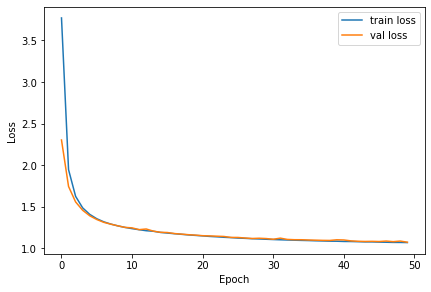

In [15]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [16]:
X_train_predict = model.predict(X_train)
X_test_predict = model.predict(X_test)
signals_zb_predict = []
for i in range(len(signals_zb)):
    signals_zb_predict.append(model.predict(signals_zb[i]))

2022-04-10 19:22:17.008943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:23:41.084973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [17]:
QCD_zb_predict = model.predict(QCD_zb)
SingleNu_E10_zb_predict = model.predict(SingleNu_E10_zb)
SingleNu_Pt2To20_zb_predict = model.predict(SingleNu_Pt2To20_zb)

### Save model

In [69]:
model.save('saved_models/convAE_model/')

2022-04-10 20:12:45.419535: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/convAE_model/assets


In [70]:
savedmodel = tf.keras.models.load_model('saved_models/convAE_model')
savedmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 18, 14, 21)        210       
_________________________________________________________________
average_pooling2d_1 (Average (None, 9, 7, 21)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 7, 19)          3610      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 7, 1)           172       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 9, 7, 25)          250       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 18, 14, 25)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 18, 14, 25)       

## Evaluate performance of the trained model

### Compute and plot loss distributions

In [18]:
X_train_mse = np.mean((X_train_predict - X_train)**2, axis = (1, 2))
X_test_mse = np.mean((X_test_predict - X_test)**2, axis = (1, 2))

signals_zb_mse = []
for i in range(len(signals_zb)):
    signals_zb_mse.append(np.mean((signals_zb_predict[i] - signals_zb[i])**2, axis = (1, 2)))

In [19]:
QCD_zb_mse = np.mean((QCD_zb_predict - QCD_zb)**2, axis = (1, 2))
SingleNu_E10_zb_mse = np.mean((SingleNu_E10_zb_predict - SingleNu_E10_zb)**2, axis = (1, 2))
SingleNu_Pt2To20_zb_mse = np.mean((SingleNu_Pt2To20_zb_predict - SingleNu_Pt2To20_zb)**2, axis = (1, 2))

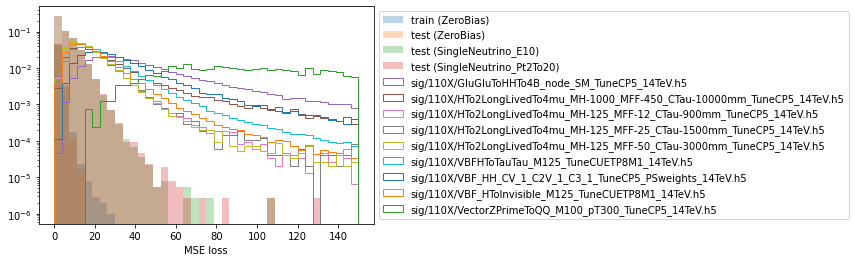

In [76]:
nbins = 40
rmin = 0
rmax = 150
plt.hist(X_train_mse, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax))
#plt.hist(QCD_zb_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (QCD)', range = (rmin, rmax))
plt.hist(SingleNu_E10_zb_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (SingleNeutrino_E10)', range = (rmin, rmax))
plt.hist(SingleNu_Pt2To20_zb_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (SingleNeutrino_Pt2To20)', range = (rmin, rmax))
#for i in range(len(signals_zb)):
for i in range(0,9):
    plt.hist(signals_zb_mse[i], density = 1, bins = nbins, label = signal_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("MSE loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

### Plot and compare the original and reconstructed inputs

SingleNu_E10 test
MSE loss = [7.43550726]


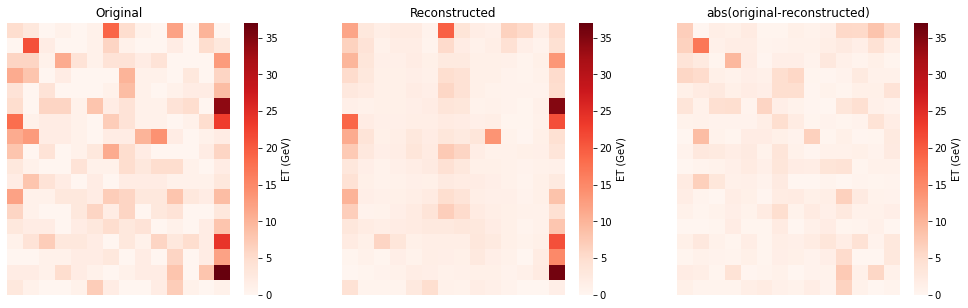

SingleNu_E10 test
MSE loss = [8.62227253]


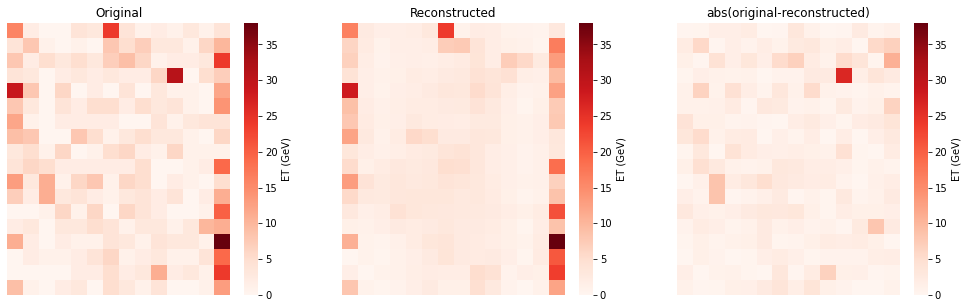

SingleNu_E10 test
MSE loss = [15.14524661]


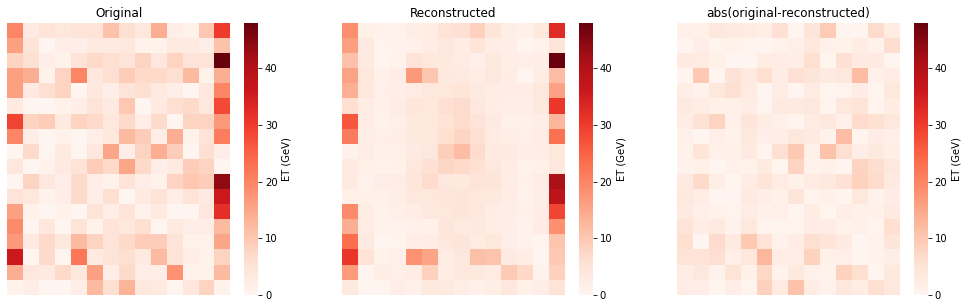

SingleNu_E10 test
MSE loss = [17.93395664]


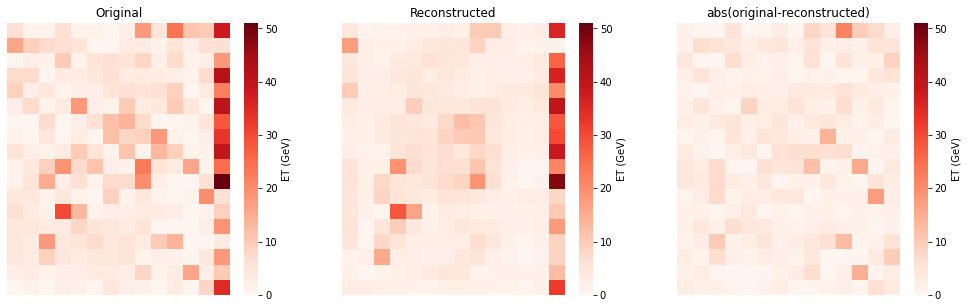

SingleNu_E10 test
MSE loss = [3.90433644]


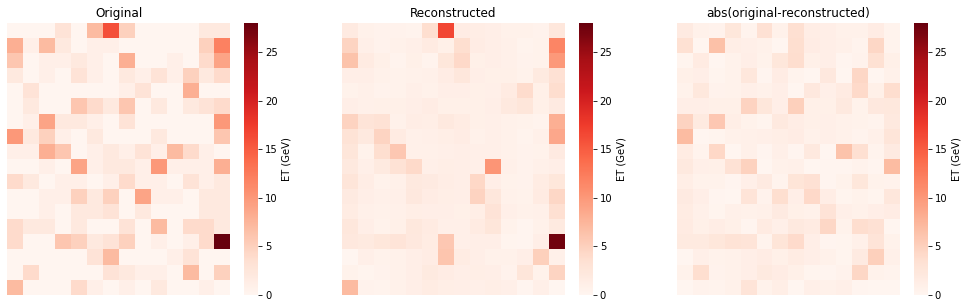

SingleNu_E10 test
MSE loss = [25.04693994]


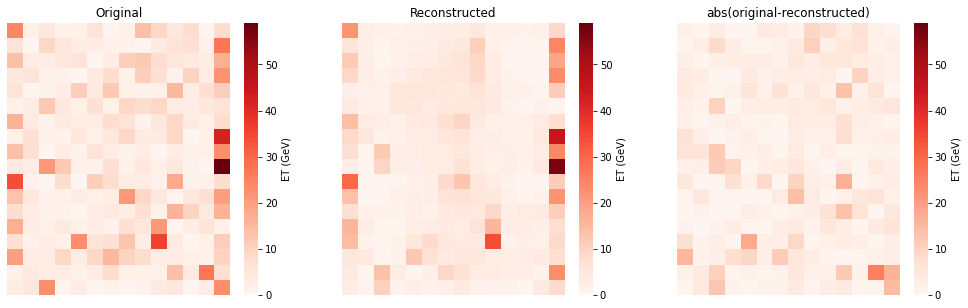

SingleNu_E10 test
MSE loss = [3.66250161]


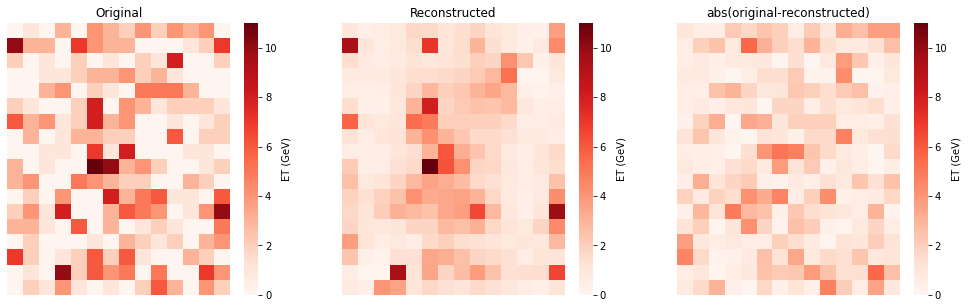

SingleNu_E10 test
MSE loss = [5.93503448]


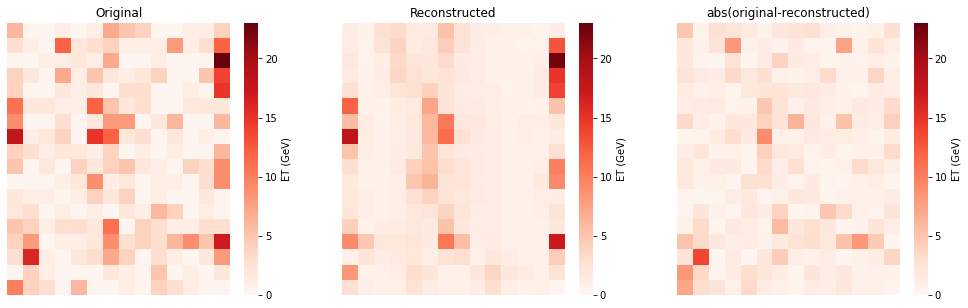

SingleNu_E10 test
MSE loss = [14.39204713]


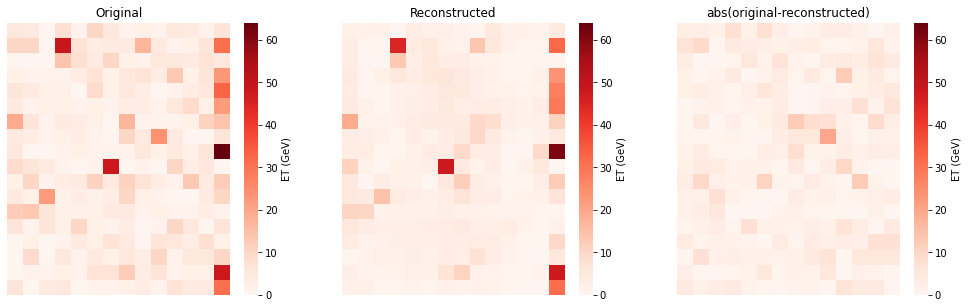

SingleNu_E10 test
MSE loss = [8.27538672]


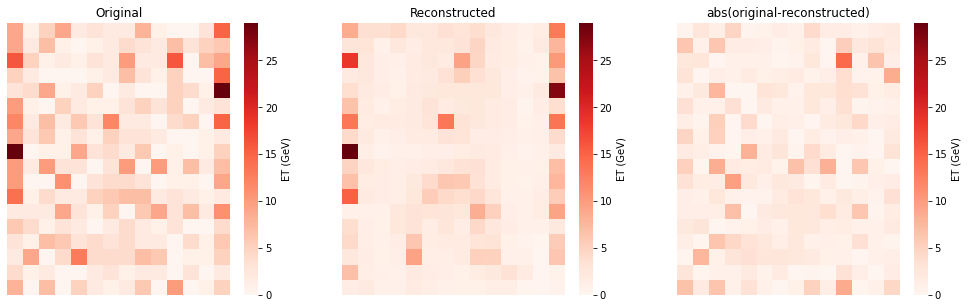

In [95]:
#Original vs Reconstructed (without annotation)
n = 46
for i in range(440,450):
    fig, ax = plt.subplots(figsize = (17,17))
    #print('ZB test\nMSE loss = ' + str(X_test_mse[i]))
    #print(str(signal_files[n]) + '\nMSE loss = ' + str(signals_zb_mse[n][i]))
    #print('QCD test\nMSE loss = ' + str(QCD_zb_mse[i]))
    print('SingleNu_E10 test\nMSE loss = ' + str(SingleNu_E10_zb_mse[i]))
    #print('SingleNu_Pt2To20 test\nMSE loss = ' + str(SingleNu_Pt2To20_zb_mse[i]))
    ax = plt.subplot(3, 3, 1)
    #ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(signals_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(QCD_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax = sns.heatmap(SingleNu_E10_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_Pt2To20_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    #ax = sns.heatmap(np.round(X_test_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(signals_zb_predict[n][i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(QCD_zb_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax = sns.heatmap(np.round(SingleNu_E10_zb_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_Pt2To20_zb_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    #ax = sns.heatmap(np.round(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(signals_zb_predict[n][i,:,:,0] - signals_zb[n][i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(QCD_zb_predict[i,:,:,0] - QCD_zb[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax = sns.heatmap(np.round(np.absolute(SingleNu_E10_zb_predict[i,:,:,0] - SingleNu_E10_zb[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(SingleNu_Pt2To20_zb_predict[i,:,:,0] - SingleNu_Pt2To20_zb[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')
    plt.show()

In [ ]:
#Original vs Reconstructed (with annotation)
n = 4
for i in range(140,150):
    fig, ax = plt.subplots(figsize = (22,22))
    print('ZB test\nMSE loss = ' + str(X_test_mse[i]))
    #print(str(signal_files[n]) + '\nMSE loss = ' + str(signals_zb_mse[n][i]))
    #print('QCD test\nMSE loss = ' + str(QCD_zb_mse[i]))
    #print('SingleNu_E10 test\nMSE loss = ' + str(SingleNu_E10_zb_mse[i]))
    #print('SingleNu_Pt2To20 test\nMSE loss = ' + str(SingleNu_Pt2To20_zb_mse[i]))
    ax = plt.subplot(3, 3, 1)
    ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(signals_zb[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(QCD_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_E10_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(SingleNu_Pt2To20_zb[i,:,:,0].reshape(18, 14), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    ax = sns.heatmap(np.round(X_test_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = X_test[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(signals_zb_predict[n][i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(QCD_zb_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_E10_zb_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(SingleNu_Pt2To20_zb_predict[i,:,:,0].reshape(18, 14), 1), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    ax = sns.heatmap(np.round(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = X_test[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(signals_zb_predict[n][i,:,:,0] - signals_zb[n][i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = signals_zb[n][i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(QCD_zb_predict[i,:,:,0] - QCD_zb[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = QCD_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(SingleNu_E10_zb_predict[i,:,:,0] - SingleNu_E10_zb[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = SingleNu_E10_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    #ax = sns.heatmap(np.round(np.absolute(SingleNu_Pt2To20_zb_predict[i,:,:,0] - SingleNu_Pt2To20_zb[i,:,:,0]).reshape(18, 14), 1), vmin = 0, vmax = SingleNu_Pt2To20_zb[i,:,:,0].max(), annot = True, linewidths = 0.5, cmap = "Reds", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original - reconstructed)')
    plt.show()

### Assign labels and concatenate testing sets for ROC plotting

In [24]:
#Benchmark model
#Just taking L2 norm of inputs
#No model, no learning!!
#Analogous to simply cutting on energies
BM_zb = np.mean(X_test**2, axis = (1, 2))
BM_QCD = np.mean(QCD_zb**2, axis = (1, 2))
BM_SingleNu_E10 = np.mean(SingleNu_E10_zb**2, axis = (1, 2))
BM_SingleNu_Pt2To20 = np.mean(SingleNu_Pt2To20_zb**2, axis = (1, 2))
BM_signals = []
for i in range(len(signals_zb)):
    BM_signals.append(np.mean(signals_zb[i]**2, axis = (1, 2)))

In [25]:
#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_zb = np.zeros((X_test.shape[0], 1))
Y_QCD = np.zeros((QCD_zb.shape[0], 1))
Y_SingleNu_E10 = np.zeros((SingleNu_E10_zb.shape[0], 1))
Y_SingleNu_Pt2To20 = np.zeros((SingleNu_Pt2To20_zb.shape[0], 1))
Y_signals = []
for i in range(len(signals)):
    Y_signals.append(np.ones((signals_zb[i].shape[0], 1)))

#Concatenate datasets to make ROC curves, i.e. signals vs ZB/QCD/SingleNu
Y_true_vs_zb = []
Y_true_vs_QCD = []
Y_true_vs_SingleNu_E10 = []
Y_true_vs_SingleNu_Pt2To20 = []
Y_BM_vs_zb = []
Y_BM_vs_QCD = []
Y_BM_vs_SingleNu_E10 = []
Y_BM_vs_SingleNu_Pt2To20 = []
Y_model_vs_zb = []
Y_model_vs_QCD = []
Y_model_vs_SingleNu_E10 = []
Y_model_vs_SingleNu_Pt2To20 = []
for i in range(len(signals)):
    Y_true_vs_zb.append(np.concatenate((Y_signals[i], Y_zb)))
    Y_BM_vs_zb.append(np.concatenate((BM_signals[i], BM_zb)))
    Y_model_vs_zb.append(np.concatenate((signals_zb_mse[i], X_test_mse)))
    
    Y_true_vs_QCD.append(np.concatenate((Y_signals[i], Y_QCD)))
    Y_BM_vs_QCD.append(np.concatenate((BM_signals[i], BM_QCD)))
    Y_model_vs_QCD.append(np.concatenate((signals_zb_mse[i], QCD_zb_mse)))
    
    Y_true_vs_SingleNu_E10.append(np.concatenate((Y_signals[i], Y_SingleNu_E10)))
    Y_BM_vs_SingleNu_E10.append(np.concatenate((BM_signals[i], BM_SingleNu_E10)))
    Y_model_vs_SingleNu_E10.append(np.concatenate((signals_zb_mse[i], SingleNu_E10_zb_mse)))
    
    Y_true_vs_SingleNu_Pt2To20.append(np.concatenate((Y_signals[i], Y_SingleNu_Pt2To20)))
    Y_BM_vs_SingleNu_Pt2To20.append(np.concatenate((BM_signals[i], BM_SingleNu_Pt2To20)))
    Y_model_vs_SingleNu_Pt2To20.append(np.concatenate((signals_zb_mse[i], SingleNu_Pt2To20_zb_mse)))

### Plot benchmark (only L2 norm on inputs, no model) ROC (signals vs ZB)

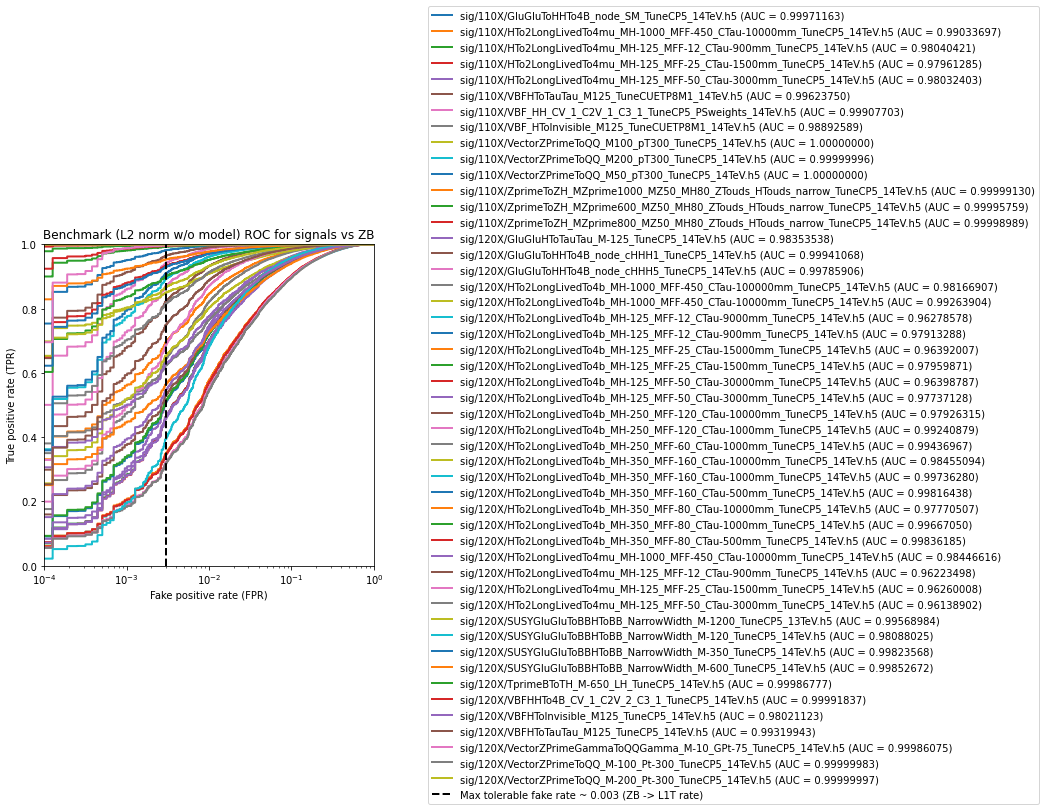

In [46]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_BM_vs_zb = []
tpr_BM_vs_zb = []
thresholds_BM_vs_zb = []
roc_auc_BM_vs_zb = []
for i in range(len(signals)):
    fpr_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    tpr_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    thresholds_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    roc_auc_BM_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    fpr_BM_vs_zb[i], tpr_BM_vs_zb[i], thresholds_BM_vs_zb[i] = roc_curve(Y_true_vs_zb[i], Y_BM_vs_zb[i])
    roc_auc_BM_vs_zb[i] = auc(fpr_BM_vs_zb[i], tpr_BM_vs_zb[i])
    axes.plot(fpr_BM_vs_zb[i], tpr_BM_vs_zb[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_BM_vs_zb[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Benchmark (L2 norm w/o model) ROC for signals vs ZB')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot benchmark (only L2 norm on inputs, no model) ROC (signals vs QCD)

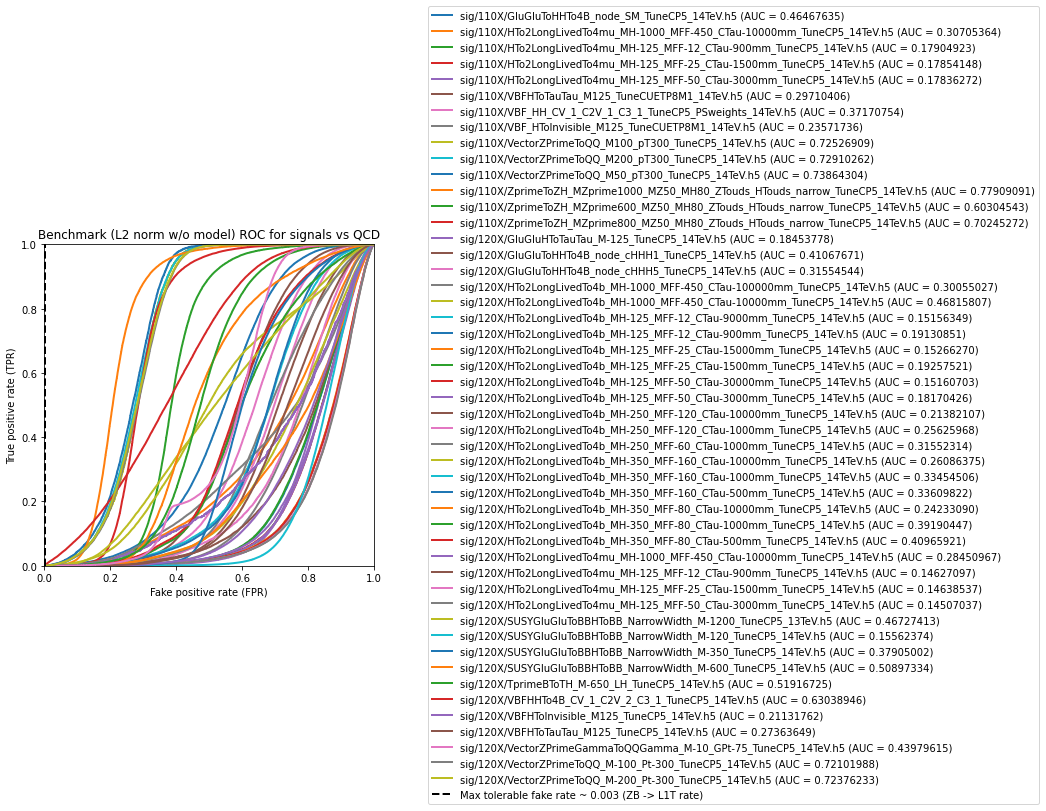

In [45]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_BM_vs_QCD = []
tpr_BM_vs_QCD = []
thresholds_BM_vs_QCD = []
roc_auc_BM_vs_QCD = []
for i in range(len(signals)):
    fpr_BM_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    tpr_BM_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    thresholds_BM_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    roc_auc_BM_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    fpr_BM_vs_QCD[i], tpr_BM_vs_QCD[i], thresholds_BM_vs_QCD[i] = roc_curve(Y_true_vs_QCD[i], Y_BM_vs_QCD[i])
    roc_auc_BM_vs_QCD[i] = auc(fpr_BM_vs_QCD[i], tpr_BM_vs_QCD[i])
    axes.plot(fpr_BM_vs_QCD[i], tpr_BM_vs_QCD[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_BM_vs_QCD[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
#axes.set_xlim([0.0001, 1.0])
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
#axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Benchmark (L2 norm w/o model) ROC for signals vs QCD')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot benchmark (only L2 norm on inputs, no model) ROC (signals vs SingleNu_E10)

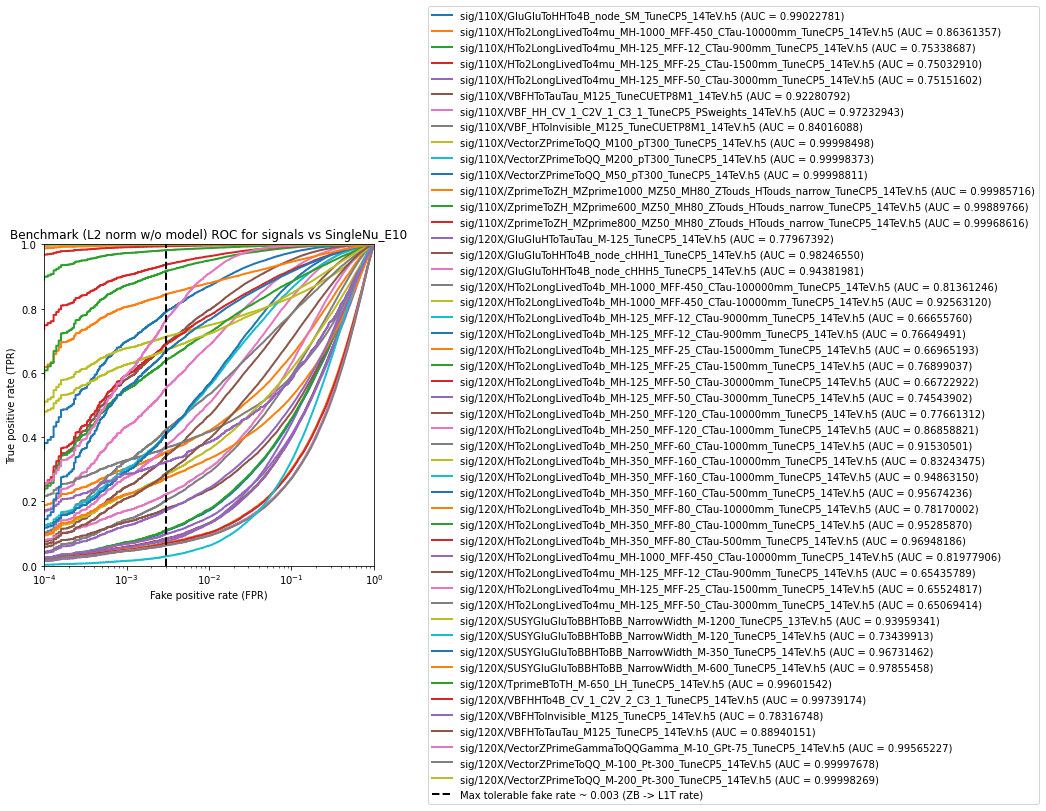

In [44]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_BM_vs_SingleNu_E10 = []
tpr_BM_vs_SingleNu_E10 = []
thresholds_BM_vs_SingleNu_E10 = []
roc_auc_BM_vs_SingleNu_E10 = []
for i in range(len(signals)):
    fpr_BM_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    tpr_BM_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    thresholds_BM_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    roc_auc_BM_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    fpr_BM_vs_SingleNu_E10[i], tpr_BM_vs_SingleNu_E10[i], thresholds_BM_vs_SingleNu_E10[i] = roc_curve(Y_true_vs_SingleNu_E10[i], Y_BM_vs_SingleNu_E10[i])
    roc_auc_BM_vs_SingleNu_E10[i] = auc(fpr_BM_vs_SingleNu_E10[i], tpr_BM_vs_SingleNu_E10[i])
    axes.plot(fpr_BM_vs_SingleNu_E10[i], tpr_BM_vs_SingleNu_E10[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_BM_vs_SingleNu_E10[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Benchmark (L2 norm w/o model) ROC for signals vs SingleNu_E10')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot benchmark (only L2 norm on inputs, no model) ROC (signals vs SingleNu_Pt2To20)

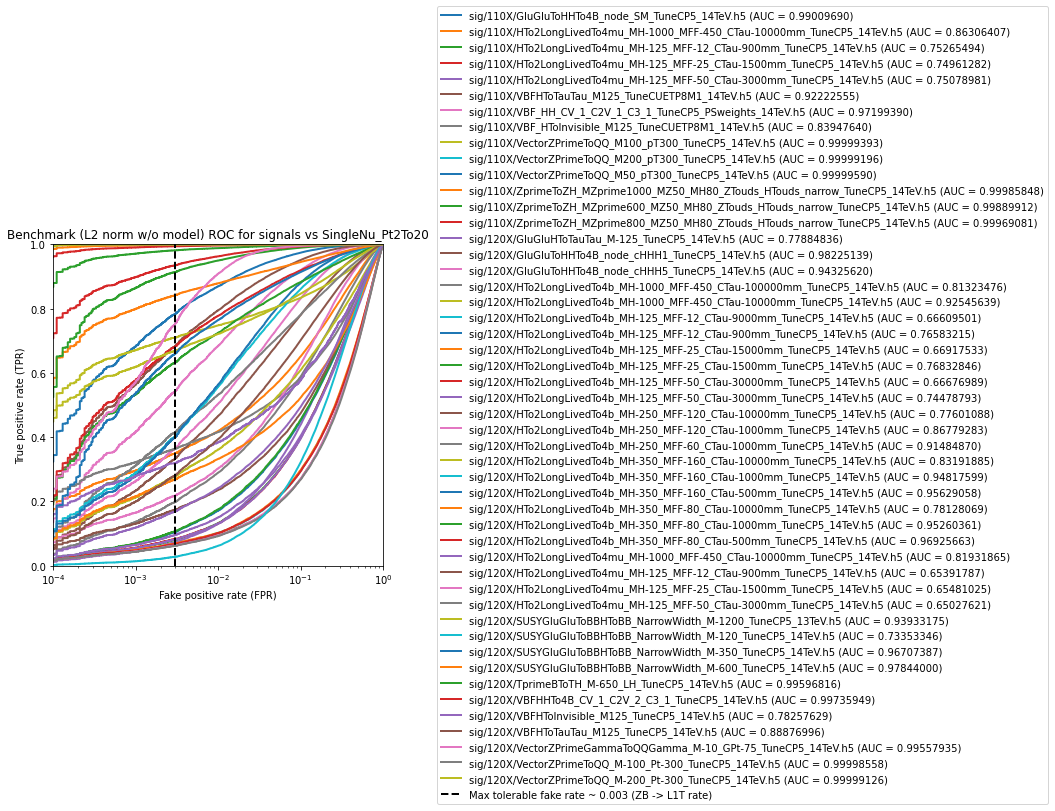

In [43]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_BM_vs_SingleNu_Pt2To20 = []
tpr_BM_vs_SingleNu_Pt2To20 = []
thresholds_BM_vs_SingleNu_Pt2To20 = []
roc_auc_BM_vs_SingleNu_Pt2To20 = []
for i in range(len(signals)):
    fpr_BM_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    tpr_BM_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    thresholds_BM_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    roc_auc_BM_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    fpr_BM_vs_SingleNu_Pt2To20[i], tpr_BM_vs_SingleNu_Pt2To20[i], thresholds_BM_vs_SingleNu_Pt2To20[i] = roc_curve(Y_true_vs_SingleNu_Pt2To20[i], Y_BM_vs_SingleNu_Pt2To20[i])
    roc_auc_BM_vs_SingleNu_Pt2To20[i] = auc(fpr_BM_vs_SingleNu_Pt2To20[i], tpr_BM_vs_SingleNu_Pt2To20[i])
    axes.plot(fpr_BM_vs_SingleNu_Pt2To20[i], tpr_BM_vs_SingleNu_Pt2To20[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_BM_vs_SingleNu_Pt2To20[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('Benchmark (L2 norm w/o model) ROC for signals vs SingleNu_Pt2To20')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot ROC (signals vs ZB)

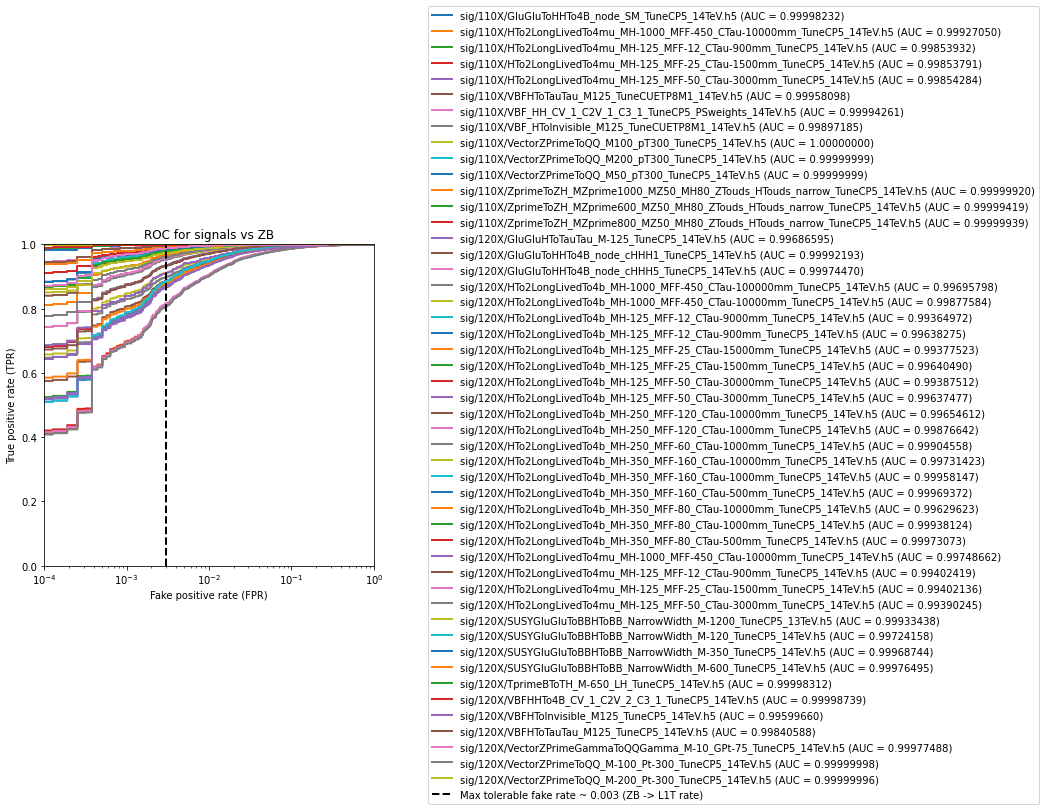

In [47]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_zb = []
tpr_vs_zb = []
thresholds_vs_zb = []
roc_auc_vs_zb = []
for i in range(len(signals)):
    fpr_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    tpr_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    thresholds_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    roc_auc_vs_zb.append(np.empty((Y_true_vs_zb[i].shape[0],1)))
    fpr_vs_zb[i], tpr_vs_zb[i], thresholds_vs_zb[i] = roc_curve(Y_true_vs_zb[i], Y_model_vs_zb[i])
    roc_auc_vs_zb[i] = auc(fpr_vs_zb[i], tpr_vs_zb[i])
    axes.plot(fpr_vs_zb[i], tpr_vs_zb[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_zb[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs ZB')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot ROC (signals vs QCD)

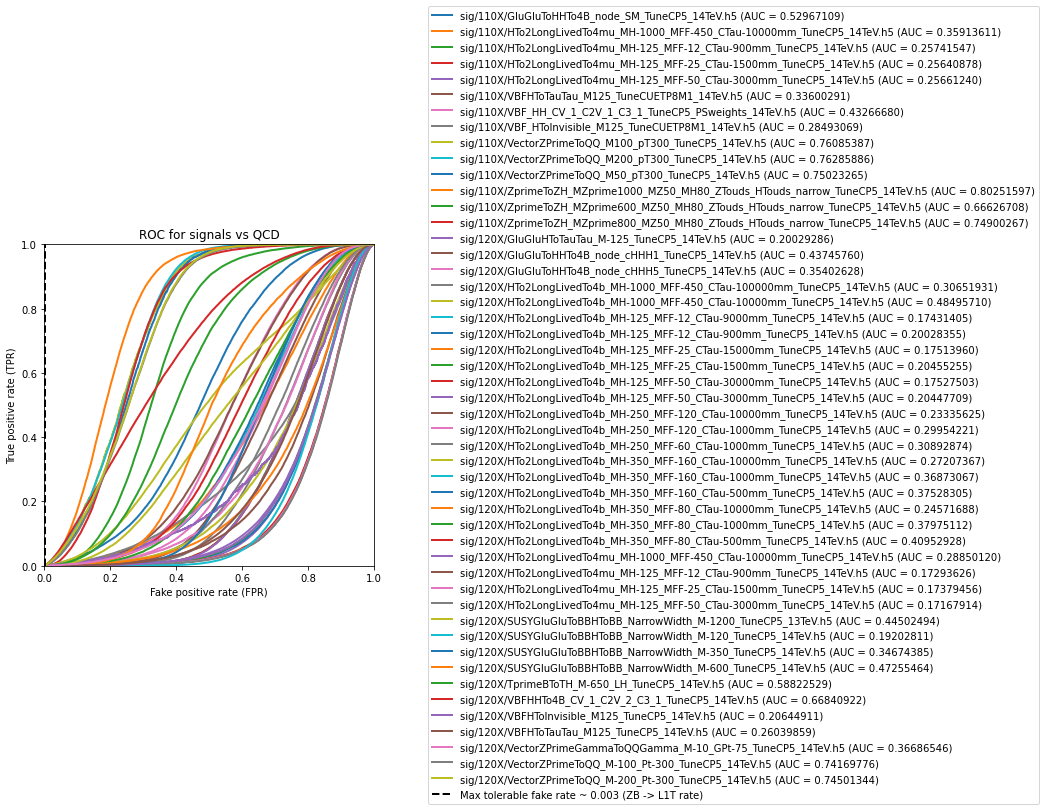

In [48]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_QCD = []
tpr_vs_QCD = []
thresholds_vs_QCD = []
roc_auc_vs_QCD = []
for i in range(len(signals)):
    fpr_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    tpr_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    thresholds_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    roc_auc_vs_QCD.append(np.empty((Y_true_vs_QCD[i].shape[0],1)))
    fpr_vs_QCD[i], tpr_vs_QCD[i], thresholds_vs_QCD[i] = roc_curve(Y_true_vs_QCD[i], Y_model_vs_QCD[i])
    roc_auc_vs_QCD[i] = auc(fpr_vs_QCD[i], tpr_vs_QCD[i])
    axes.plot(fpr_vs_QCD[i], tpr_vs_QCD[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_QCD[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
#axes.set_xlim([0.0001, 1.0])
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
#axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs QCD')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot ROC (signals vs SingleNu_E10)

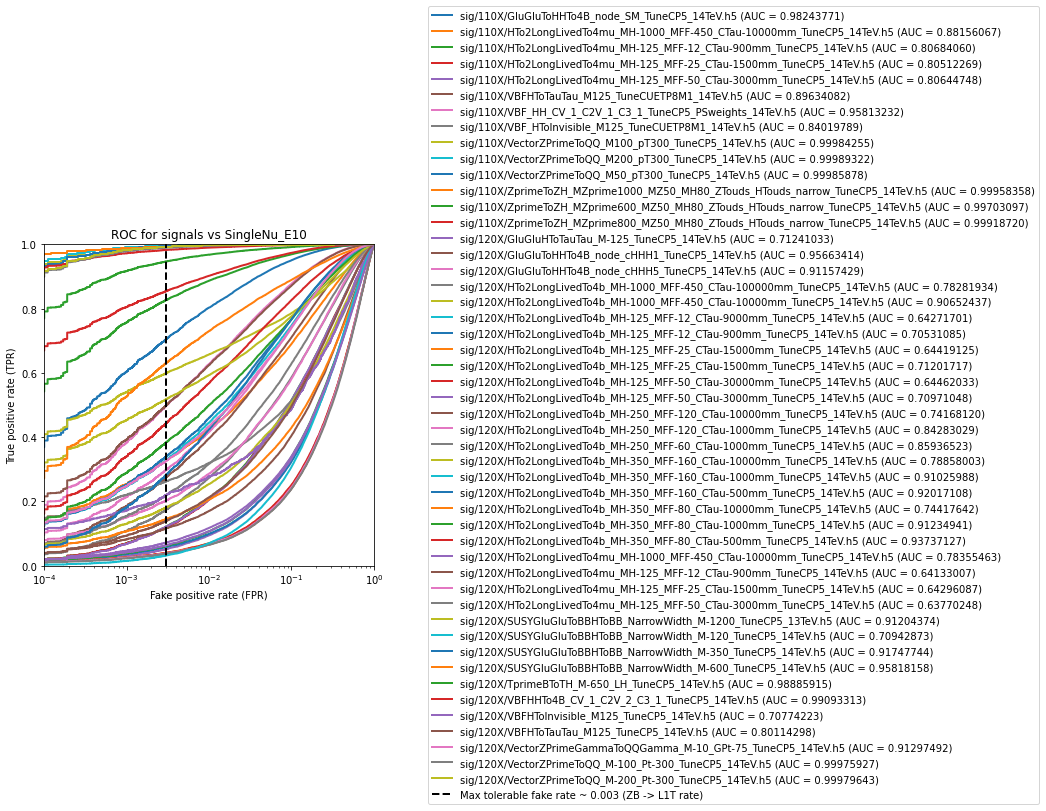

In [49]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_SingleNu_E10 = []
tpr_vs_SingleNu_E10 = []
thresholds_vs_SingleNu_E10 = []
roc_auc_vs_SingleNu_E10 = []
for i in range(len(signals)):
    fpr_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    tpr_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    thresholds_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    roc_auc_vs_SingleNu_E10.append(np.empty((Y_true_vs_SingleNu_E10[i].shape[0],1)))
    fpr_vs_SingleNu_E10[i], tpr_vs_SingleNu_E10[i], thresholds_vs_SingleNu_E10[i] = roc_curve(Y_true_vs_SingleNu_E10[i], Y_model_vs_SingleNu_E10[i])
    roc_auc_vs_SingleNu_E10[i] = auc(fpr_vs_SingleNu_E10[i], tpr_vs_SingleNu_E10[i])
    axes.plot(fpr_vs_SingleNu_E10[i], tpr_vs_SingleNu_E10[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_SingleNu_E10[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs SingleNu_E10')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Plot ROC (signals vs SingleNu_Pt2To20)

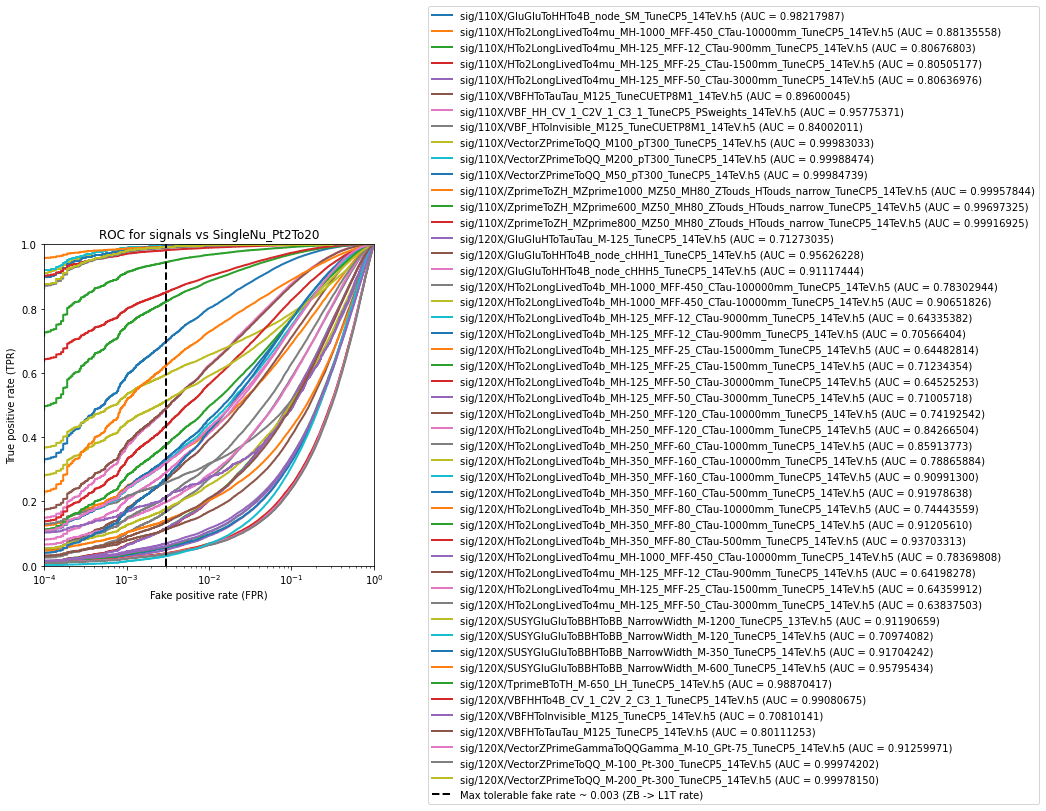

In [50]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_vs_SingleNu_Pt2To20 = []
tpr_vs_SingleNu_Pt2To20 = []
thresholds_vs_SingleNu_Pt2To20 = []
roc_auc_vs_SingleNu_Pt2To20 = []
for i in range(len(signals)):
    fpr_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    tpr_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    thresholds_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    roc_auc_vs_SingleNu_Pt2To20.append(np.empty((Y_true_vs_SingleNu_Pt2To20[i].shape[0],1)))
    fpr_vs_SingleNu_Pt2To20[i], tpr_vs_SingleNu_Pt2To20[i], thresholds_vs_SingleNu_Pt2To20[i] = roc_curve(Y_true_vs_SingleNu_Pt2To20[i], Y_model_vs_SingleNu_Pt2To20[i])
    roc_auc_vs_SingleNu_Pt2To20[i] = auc(fpr_vs_SingleNu_Pt2To20[i], tpr_vs_SingleNu_Pt2To20[i])
    axes.plot(fpr_vs_SingleNu_Pt2To20[i], tpr_vs_SingleNu_Pt2To20[i], lw = 2, label = signal_files[i] + ' (AUC = %.8f)' % (roc_auc_vs_SingleNu_Pt2To20[i]))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
axes.set_xlim([0.0001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('Fake positive rate (FPR)')
axes.set_ylabel('True positive rate (TPR)')
axes.set_title('ROC for signals vs SingleNu_Pt2To20')
axes.legend(loc='center left', bbox_to_anchor = (1.15, 0.5))
plt.show()

### Tabulate TPR at fixed FPR = 0.003 (benchmark, model, change) (signals vs ZB)

In [65]:
table_tpr_BM_vs_zb = []
table_tpr_model_vs_zb = []
table_change_vs_zb = []
for i in range(len(fpr_BM_vs_zb)):
    for j in range(len(fpr_BM_vs_zb[i])):
        if fpr_BM_vs_zb[i][j] > 0.003:
            table_tpr_BM_vs_zb.append(tpr_BM_vs_zb[i][j] * 100)
            break
    for j in range(len(fpr_vs_zb[i])):
        if fpr_vs_zb[i][j] > 0.003:
            table_tpr_model_vs_zb.append(tpr_vs_zb[i][j] * 100)
            break
for i in range(len(signals)):
    table_change_vs_zb.append(100 * (table_tpr_model_vs_zb[i] - table_tpr_BM_vs_zb[i])/table_tpr_BM_vs_zb[i])
    
table_tpr_vs_zb = pd.DataFrame({'Benchmark TPR at FPR = 0.3%': table_tpr_BM_vs_zb,
                          'Model TPR at FPR = 0.3%': table_tpr_model_vs_zb,
                          '% increase in TPR at FPR = 0.3%': table_change_vs_zb},
                        index = signal_files)
table_tpr_vs_zb = table_tpr_vs_zb.sort_values(by = '% increase in TPR at FPR = 0.3%', ascending = False)
pd.set_option('display.max_colwidth', None)
table_tpr_vs_zb

Benchmark TPR at FPR = 0.3%  \
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                             31.766719   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                              32.017322   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                             32.148574   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5                             34.536082   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5                              34.745907   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5                             34.973396   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5                                    39.459000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                             45.747500   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                              46.165000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                             46.261538   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                              46.323806   
sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5                                                    50.772667   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                               50.980643   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                              51.302500   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5                            52.892368   
sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5                                                     54.621905   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5                             56.460000   
sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5                                               64.247079   
sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          63.028169   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5                          62.335259   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5                            65.343537   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5                             68.667907   
sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          69.551580   
sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5                                                        74.940712   
sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5                                                   82.280667   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5                              81.500930   
sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5                                                87.047000   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                           85.011879   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5                                   86.721873   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5                             89.210540   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5                              90.106582   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5                              91.001146   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5                                    93.029002   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5                               93.419290   
sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5                                         94.193333   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_Tu

### Tabulate TPR at fixed FPR = 0.003 (benchmark, model, change) (signals vs QCD)

In [66]:
table_tpr_BM_vs_QCD = []
table_tpr_model_vs_QCD = []
table_change_vs_QCD = []
for i in range(len(fpr_BM_vs_QCD)):
    for j in range(len(fpr_BM_vs_QCD[i])):
        if fpr_BM_vs_QCD[i][j] > 0.003:
            table_tpr_BM_vs_QCD.append(tpr_BM_vs_QCD[i][j] * 100)
            break
    for j in range(len(fpr_vs_QCD[i])):
        if fpr_vs_QCD[i][j] > 0.003:
            table_tpr_model_vs_QCD.append(tpr_vs_QCD[i][j] * 100)
            break
for i in range(len(signals)):
    table_change_vs_QCD.append(100 * (table_tpr_model_vs_QCD[i] - table_tpr_BM_vs_QCD[i])/table_tpr_BM_vs_QCD[i])
    
table_tpr_vs_QCD = pd.DataFrame({'Benchmark TPR at FPR = 0.3%': table_tpr_BM_vs_QCD,
                          'Model TPR at FPR = 0.3%': table_tpr_model_vs_QCD,
                          '% increase in TPR at FPR = 0.3%': table_change_vs_QCD},
                        index = signal_files)
table_tpr_vs_QCD = table_tpr_vs_QCD.sort_values(by = '% increase in TPR at FPR = 0.3%', ascending = False)
pd.set_option('display.max_colwidth', None)
table_tpr_vs_QCD

/var/folders/cq/wd3sjbj1295gnsm9jg9tzv3w0000gn/T/ipykernel_27985/11142658.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  table_change_vs_QCD.append(100 * (table_tpr_model_vs_QCD[i] - table_tpr_BM_vs_QCD[i])/table_tpr_BM_vs_QCD[i])
/var/folders/cq/wd3sjbj1295gnsm9jg9tzv3w0000gn/T/ipykernel_27985/11142658.py:14: RuntimeWarning: invalid value encountered in double_scalars
  table_change_vs_QCD.append(100 * (table_tpr_model_vs_QCD[i] - table_tpr_BM_vs_QCD[i])/table_tpr_BM_vs_QCD[i])


Benchmark TPR at FPR = 0.3%  \
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5                               0.000000   
sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5                                                      0.000000   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5                                     0.000000   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5                                    0.000000   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5                                0.000000   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5                               0.000000   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5                              0.000000   
sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5                                                         0.000000   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5                              0.000000   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5                             0.000000   
sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                           0.000000   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5                              0.000000   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5                           0.000000   
sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5                                                 0.000000   
sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5                                                 0.000000   
sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5                                               0.000000   
sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5                                                0.000000   
sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5                                          0.000000   
sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5                                                    0.000000   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                            0.002501   
sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5                                               0.007890   
sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5                                                      0.001015   
sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5                                             0.012410   
sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                     0.004000   
sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5                                                0.015911   
sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5                                             0.015564   
sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                      0.002000   
sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5                                                    0.006000   
sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5                                    0.002429   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5                               0.006193   
sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5                                                 0.246000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                               0.000000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                              0.000000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                              0.000000   
sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                      0.000000   
sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5  

### Tabulate TPR at fixed FPR = 0.003 (benchmark, model, change) (signals vs SingleNu_E10)

In [67]:
table_tpr_BM_vs_SingleNu_E10 = []
table_tpr_model_vs_SingleNu_E10 = []
table_change_vs_SingleNu_E10 = []
for i in range(len(fpr_BM_vs_SingleNu_E10)):
    for j in range(len(fpr_BM_vs_SingleNu_E10[i])):
        if fpr_BM_vs_SingleNu_E10[i][j] > 0.003:
            table_tpr_BM_vs_SingleNu_E10.append(tpr_BM_vs_SingleNu_E10[i][j] * 100)
            break
    for j in range(len(fpr_vs_SingleNu_E10[i])):
        if fpr_vs_SingleNu_E10[i][j] > 0.003:
            table_tpr_model_vs_SingleNu_E10.append(tpr_vs_SingleNu_E10[i][j] * 100)
            break
for i in range(len(signals)):
    table_change_vs_SingleNu_E10.append(100 * (table_tpr_model_vs_SingleNu_E10[i] - table_tpr_BM_vs_SingleNu_E10[i])/table_tpr_BM_vs_SingleNu_E10[i])
    
table_tpr_vs_SingleNu_E10 = pd.DataFrame({'Benchmark TPR at FPR = 0.3%': table_tpr_BM_vs_SingleNu_E10,
                          'Model TPR at FPR = 0.3%': table_tpr_model_vs_SingleNu_E10,
                          '% increase in TPR at FPR = 0.3%': table_change_vs_SingleNu_E10},
                        index = signal_files)
table_tpr_vs_SingleNu_E10 = table_tpr_vs_SingleNu_E10.sort_values(by = '% increase in TPR at FPR = 0.3%', ascending = False)
pd.set_option('display.max_colwidth', None)
table_tpr_vs_SingleNu_E10

Benchmark TPR at FPR = 0.3%  \
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                               8.220000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                              8.360000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                              8.500000   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5                                     2.927200   
sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5                                              99.989480   
sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5                                              100.000000   
sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                    99.808000   
sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5                                             100.000000   
sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5                                            99.992218   
sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5                                            99.992554   
sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                     99.454000   
sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                     98.220000   
sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          35.379288   
sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5                                                93.742000   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5                             22.302579   
sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5                                                     91.723872   
sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5                                         55.393333   
sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5                                                   79.080000   
sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5                                               20.383849   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                           71.271727   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5                              41.052240   
sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5                                                   34.185667   
sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5                                                37.317000   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5                             41.138714   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5                                   67.237872   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5                                    84.511406   
sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5                                                69.228000   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5                          36.751944   
sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5                                                     7.526667   
sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          32.394366   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5                            17.720371   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5                               68.958473   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                               9.891987   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5                            28.377974   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5                              63.897754   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-15

### Tabulate TPR at fixed FPR = 0.003 (benchmark, model, change) (signals vs SingleNu_Pt2To20)

In [68]:
table_tpr_BM_vs_SingleNu_Pt2To20 = []
table_tpr_model_vs_SingleNu_Pt2To20 = []
table_change_vs_SingleNu_Pt2To20 = []
for i in range(len(fpr_BM_vs_SingleNu_Pt2To20)):
    for j in range(len(fpr_BM_vs_SingleNu_Pt2To20[i])):
        if fpr_BM_vs_SingleNu_Pt2To20[i][j] > 0.003:
            table_tpr_BM_vs_SingleNu_Pt2To20.append(tpr_BM_vs_SingleNu_Pt2To20[i][j] * 100)
            break
    for j in range(len(fpr_vs_SingleNu_Pt2To20[i])):
        if fpr_vs_SingleNu_Pt2To20[i][j] > 0.003:
            table_tpr_model_vs_SingleNu_Pt2To20.append(tpr_vs_SingleNu_Pt2To20[i][j] * 100)
            break
for i in range(len(signals)):
    table_change_vs_SingleNu_Pt2To20.append(100 * (table_tpr_model_vs_SingleNu_Pt2To20[i] - table_tpr_BM_vs_SingleNu_Pt2To20[i])/table_tpr_BM_vs_SingleNu_Pt2To20[i])
    
table_tpr_vs_SingleNu_Pt2To20 = pd.DataFrame({'Benchmark TPR at FPR = 0.3%': table_tpr_BM_vs_SingleNu_Pt2To20,
                          'Model TPR at FPR = 0.3%': table_tpr_model_vs_SingleNu_Pt2To20,
                          '% increase in TPR at FPR = 0.3%': table_change_vs_SingleNu_Pt2To20},
                        index = signal_files)
table_tpr_vs_SingleNu_Pt2To20 = table_tpr_vs_SingleNu_Pt2To20.sort_values(by = '% increase in TPR at FPR = 0.3%', ascending = False)
pd.set_option('display.max_colwidth', None)
table_tpr_vs_SingleNu_Pt2To20

Benchmark TPR at FPR = 0.3%  \
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5                               8.000000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                              8.125000   
sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5                              8.315385   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5                                     2.772000   
sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5                                              99.989480   
sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5                                              100.000000   
sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                    99.802000   
sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5                                             100.000000   
sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5                                            99.992218   
sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5                                            99.992554   
sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                     99.438000   
sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5                     98.168000   
sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          35.015432   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5                             21.839936   
sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5                                                93.525000   
sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5                                                     91.429384   
sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5                                         54.360000   
sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5                                                   78.414000   
sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5                                               19.853265   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                           71.006627   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5                              40.067507   
sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5                                                   33.345667   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5                             40.273375   
sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5                                                36.479000   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV.h5                                   66.898021   
sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5                                    84.207063   
sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5                                                68.410000   
sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5                          36.401831   
sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5                                                     7.251000   
sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5                          31.901408   
sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5                            17.411314   
sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5                               9.550285   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5                               68.231748   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5                            27.835635   
sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5                              63.256458   
sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-15

### Plot ROC, split in TPR ranges at FPR = 0.003

In [ ]:
#Split ROC by efficiency range
sig_idx_eff_0to50 = []
sig_idx_eff_50to60 = []
sig_idx_eff_60to70 = []
sig_idx_eff_70to80 = []
sig_idx_eff_80to90 = []
sig_idx_eff_90to95 = []
sig_idx_eff_95to99 = []
sig_idx_eff_99to100 = []

for i in range(len(fpr_vs_zb)):
    for j in range(len(fpr_vs_zb[i])):
        if fpr_vs_zb[i][j] > 0.003:
            if tpr_vs_zb[i][j] > 0.99:
                sig_idx_eff_99to100.append(i)
            elif tpr_vs_zb[i][j] > 0.95:
                sig_idx_eff_95to99.append(i)
            elif tpr_vs_zb[i][j] > 0.9:
                sig_idx_eff_90to95.append(i)
            elif tpr_vs_zb[i][j] > 0.8:
                sig_idx_eff_80to90.append(i)
            elif tpr_vs_zb[i][j] > 0.7:
                sig_idx_eff_70to80.append(i)
            elif tpr_vs_zb[i][j] > 0.6:
                sig_idx_eff_60to70.append(i)
            elif tpr_vs_zb[i][j] > 0.5:
                sig_idx_eff_50to60.append(i)
            else:
                sig_idx_eff_0to50.append(i)
            break
sig_idx_eff_all = []
sig_idx_eff_all.append(sig_idx_eff_0to50)
sig_idx_eff_all.append(sig_idx_eff_50to60)
sig_idx_eff_all.append(sig_idx_eff_60to70)
sig_idx_eff_all.append(sig_idx_eff_70to80)
sig_idx_eff_all.append(sig_idx_eff_80to90)
sig_idx_eff_all.append(sig_idx_eff_90to95)
sig_idx_eff_all.append(sig_idx_eff_95to99)
sig_idx_eff_all.append(sig_idx_eff_99to100)

In [ ]:
# Plot ROC by efficiency range
for i in range(len(sig_idx_eff_all)):
    plt.figure(figsize = (13, 13))
    axes = plt.subplot(2, 2, 1)
    for j in range(len(sig_idx_eff_all[i])):
        axes.plot(fpr_vs_zb[sig_idx_eff_all[i][j]], tpr_vs_zb[sig_idx_eff_all[i][j]], lw = 2, label = signal_files[sig_idx_eff_all[i][j]] + ' (AUC = %.8f)' % (roc_auc_vs_zb[sig_idx_eff_all[i][j]]))
    #axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
    axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB -> L1T rate)')
    axes.set_xlim([0.0001, 1.0])
    #axes.set_xlim([0, 1.0])
    axes.set_ylim([0, 1.0])
    #axes.set_ylim([0.99, 1.0])
    axes.set_xscale(value = "log")
    #axes.set_yscale(value = "log")
    axes.set_xlabel('Fake positive rate (FPR)')
    axes.set_ylabel('True positive rate (TPR)')
    axes.set_title('ROC for signals vs ZB')
    axes.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.show()